In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy

%matplotlib inline

In [202]:
# input grid init should have 2 extra columns and 2 extra rows for BCs, -1 for down spins, and 1 for up spins
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh, ignoring the edges
    spin = [random.choice(range(Y)),random.choice(range(X))]
    
    # applying the metropolis algorithm
    spin_sum = (mesh[(spin[0]+1) % Y,spin[1] ] + mesh[spin[0] ,(spin[1]+1)  % X] 
                + mesh[(spin[0]-1)  % Y,spin[1] ] + mesh[spin[0] ,(spin[1]-1)  % X])
    d_energy = 2*mesh[spin[0],spin[1]] * spin_sum
    
    if d_energy > 0:
        accept_prob = boltz[str(abs(spin_sum))]

        sample = random.uniform(0,1)
        
        if sample > accept_prob:
            d_energy = 0
            d_mag = 0
        
        else:
            mesh[spin[0],spin[1]] = -1*mesh[spin[0],spin[1]]
            d_mag = 2*mesh[spin[0],spin[1]]
            
    else:
        mesh[spin[0],spin[1]] = -1*mesh[spin[0],spin[1]]
        d_mag = 2*mesh[spin[0],spin[1]]
    

    return [mesh, d_energy, d_mag]

In [203]:
# the input grid uses 2 extra columns and 2 extra rows for BCs
# assumes periodic BCs
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [212]:
ising_energy(solution)

20.0

In [205]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)


    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, X))
    ax.set_yticks(np.arange(-0.45,Y))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [206]:
def met_ising(init, boltz, n, final_only = True):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = init[:,:]
    
    for i in range(n):    
        # evolve using metropolis
        evo = metropolis_ising(grid, boltz)[0]
        
        # plotting
        if final_only == False:    
            plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')
        
        
        else:
            if i == n-1:
                plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')
        
        # reset iteration variable
        grid = evo[:,:]
        
    return evo

In [207]:
test = 1*np.ones((30,30))

T = 1000

test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

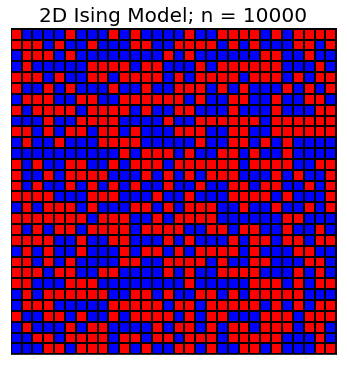

In [211]:
init = test[:,:]

random.seed(1)
solution = met_ising(init, test_boltz, 10000)

In [243]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


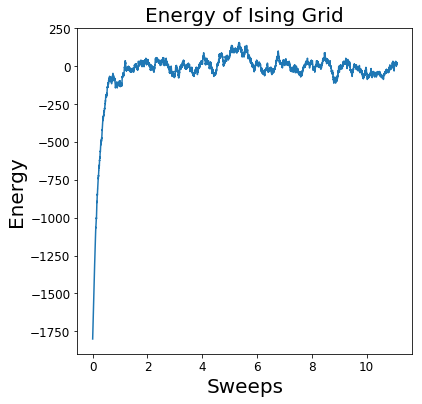

In [244]:
init = test[:,:]


random.seed(1)
e_list = energy_evo(init, test_boltz, 10000)

In [252]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag)
    
        # reset iteration variable
        grid = evo[:,:]

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

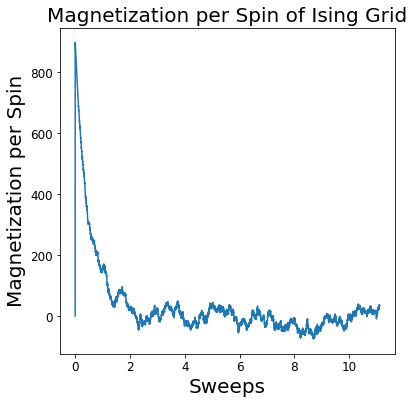

In [253]:
random.seed(1)
m_list = magps(init, test_boltz,10000)

In [254]:
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at temperature T and lattice sites N"""
    
    moment_1 = np.sum(energy_list)/len(energy_list)
    moment_2 = np.sum([i**2 for i in energy_list])/len(energy_list)
    
    c = (1/(T**2 * N)) * (moment_2 - moment_1**2)
    
    return c

In [255]:
def sus(mag_list, T, N):
    """Compute susceptibility for an input list of mag per spin values at temperature T and lattice sites N"""
    
    moment_1 = np.sum(mag_list)/len(mag_list)
    moment_2 = np.sum([i**2 for i in mag_list])/len(mag_list)
    
    chi = (N/T) * (moment_2 - moment_1**2)
    
    return chi

In [256]:
# c_list is a list of specific heats per spin computed at the evenly-spaced, ascending order temperatures on temp_list
#s_0 is the entropy per spin at the the minimum of temp_list 
def ent_ps(temp_list, c_list, s_0):
    """Compute the entropy of an Ising lattice using the trapezoidal rule for a given set of temperatures and c"""
    
    dT = temp_list[1] - temp_list[0]
    n = len(temp_list)
    
    # compute the boundary terms
    t_min = t[0]
    t_max = t[-1]
    
    c_1 = c_list[0]
    c_2 = c_list[-1]
    
    boundary = (c_2/t_max + c_1/t_min)
    
    
    # initialize the integral sum
    integral = boundary
    
    for i in range(1,n-1):
        integral += c_list[i]/temp_list[i]
        
    integral = integral*dT
    
    # include the integration constant
    s = s_0 + integral
    
    return s
    

In [231]:
temps = []

for i in range(100,205, 5):
    temps.append(i)